# Goals

Build a simple chain within our graph that uses 4 concepts/tools
- Use chat messages in the graph
- Invoking chat models within graph
- Binding tools to out LLM
- Executing tool calls in our graph

In [8]:
import os, getpass
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv
from IPython.display import Image

# Import langgraph modules to create and visualize the graph
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Literal


In [ ]:
def set_api_key(var):
    try:
        
        # Load the .env file
        env_path = find_dotenv()
        
        # If the .env file is not found, raise an error
        if not env_path:
            raise FileNotFoundError('.env file not found')

        # Load the .env file
        load_dotenv(env_path, override=True)

        # Get the API key from the .env file
        api_key = os.environ.get(var)

        # If the API key is not found, raise an error
        if not api_key:
            raise KeyError(f'{var} not found in .env file')
        
        print(f"API key found in .env file for {var}")

    except FileNotFoundError as e:
        print(f"Error: {e}")
    except KeyError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Error: {e}")

In [62]:
GROQ_API_KEY = set_api_key('GROQ_API_KEY')

API key found in .env file for GROQ_API_KEY


## Creating a simple graph with 3 nodes


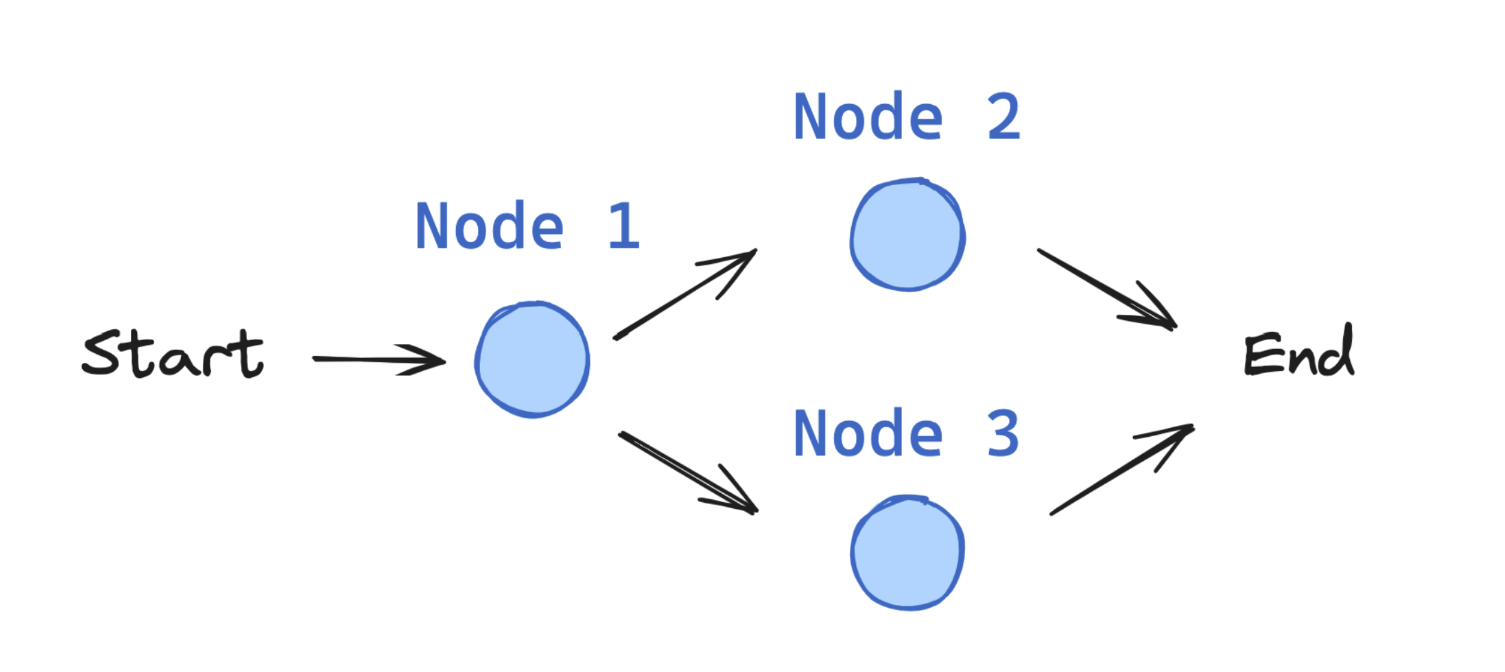

In [10]:
Image(filename='3-node-graph.png', width = 600, height=400)

In [76]:
# Define the state of the graph, in our case, we are only working with one state with two schema keys to describe the state of the graph.
# State is basically the object that is passed among the nodes based on the graph traversal.
# Inside the state, we have a schema with different channels (keys),these keys are typically going through each node and updated based on the output.
# Eevery node does its work and updates the state object (schema) and passes it to the next node through the edges.

class OverallState(TypedDict):
    user_input:str
    graph_state: str
    graph_output: str

### Building nodes

In [77]:
# create node 1
def node1(OverallState):
    print("Node 1")
    return {'user_input': OverallState["user_input"],
            'graph_state': OverallState["graph_state"] + " -> Node 1"}

In [95]:
# create node 2
def node2(OverallState):
    print("Node 2")
    user_input = str(OverallState["user_input"])
    return {'graph_state': OverallState["graph_state"] + " -> Node 2", 
             'graph_output':  "I am " + user_input + " and I am happy!"}

In [96]:
# create node 3
def node3(OverallState):
    print("Node 3")
    user_input = str(OverallState["user_input"])
    return {'graph_state': OverallState["graph_state"] + " -> Node 3", 
            'graph_output':  "I am " + user_input + " and I am tired!"}

### Building edges

In [97]:
# Edges simply connect the nodes and pass the state object from one node to another.
# Based on the updates in state object at each node, we can have either straightforward or conditional edges.
# We will be using a conditional edge in this example. If the age is less than 18, we will go to node 2, otherwise, we will go to node 3.

def routing_logic(OverallState) -> Literal["node2", "node3"]:
    try:
        user_input = int(OverallState["user_input"])
        if user_input < 0 or user_input > 150:
            raise ValueError("Invalid age")
        if user_input < 18:
            return "node2"
        
        return "node3"
    except ValueError as e:
        print(f"Error: {e}")


### Graph Contruction
<p> The StateGraph class is the main class to be used.<p>

- We initialize the StateGraph with the state class we defined, followed by adding nodes and edges.
- START node is a special node that sends user input to the graph, to indicate where to start our graph.
- END nodes is a special node that represents a terminal node.
- Graph compilation is the process to create a few basic checks about the structure of the graph./

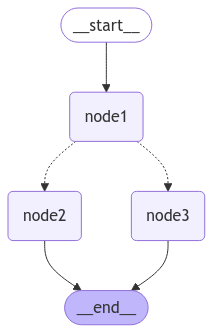

In [101]:
# Build graph
graph_builder = StateGraph(OverallState)
graph_builder.add_node("node1", node1)
graph_builder.add_node("node2", node2)
graph_builder.add_node("node3", node3)

# Graph logic
graph_builder.add_edge(START, "node1")
graph_builder.add_conditional_edges("node1", routing_logic)
graph_builder.add_edge("node2", END)
graph_builder.add_edge("node3", END)

# Compile graph
graph = graph_builder.compile()

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

- The compiled graph implements the runnable protocol. This provides a standard way to execute LangChain components.
- *invoke* is one of the standard methods in this interface. It sends the message to START node and triggers graph execution.
- The input is a dictionary {"user_input": 32, "graph_state":Node1} which sets the initial value to our graph state dict.
- After invocation, the graph progresses through the defined nodes in order.
- The conditional edge will route the graph based on the routing function.
- Each node received the current state and overrides it.
- The execution continues till it reaches the END node.


In [104]:
graph.invoke(OverallState(user_input=24, graph_state="START"))

Node 1
Node 3


{'user_input': 24,
 'graph_state': 'START -> Node 1 -> Node 3',
 'graph_output': 'I am 24 and I am tired!'}